In [1]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score

from torch import nn

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from synexp import *
from viz import *
from mlp import *

y0_pdf = 'sinusoid'
y1_pdf = 'low_base_rate_sinusoid'
pi_pdf = 'linear'

/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Example code invoking experiemnt setup functions
expdf, error_params = generate_syn_data(
    NS=5000,
    y0_pdf=y0_pdf,
    y1_pdf=y1_pdf,
    pi_pdf='linear',
    error_min=0.05,
    error_max=0.25
)

In [3]:
do=0
exp_data = expdf.copy()
exp_data = exp_data.sample(frac=1).reset_index(drop=True)
split_ix = int(exp_data.shape[0]*.7)
train_df, val_df = exp_data.iloc[:split_ix,:], exp_data.iloc[split_ix:,:]
train_df = train_df[train_df['D'] == do]

clf = MLPClassifier(alpha=0, hidden_layer_sizes=(40, 4))
clf.fit(train_df['X'].to_numpy().reshape(-1, 1), train_df['YS_0'])

pyhat = clf.predict_proba(val_df['X'].to_numpy().reshape(-1, 1))
auroc = roc_auc_score(val_df['YS_0'], pyhat[:, 1])

print('Sanity check AU-ROC', auroc)


Sanity check AU-ROC 0.8839472238470552


In [4]:
# def train(model, train_loader, loss_func, n_epochs):
    
#     opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
#     epoch_loss = []

#     for epoch in tqdm(range(0, n_epochs)):
#         current_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             inputs, targets = data
#             opt.zero_grad()
#             outputs = model(inputs)
#             loss = loss_func(outputs, targets)
#             loss.backward()
#             opt.step()
#             current_loss += loss.item()
        
#         epoch_loss.append(current_loss)
#         current_loss = 0.0
        
        
        
#     return epoch_loss

# def evaluate(model, val_loader):
#     labels = []
#     preds = []
    
#     for i, data in enumerate(val_loader, 0):
#         inputs, targets = data
#         outputs = model(inputs)
#         preds.append(outputs)
#         labels.append(targets)

#     py_hat = torch.cat(preds, dim=0).detach().numpy()
#     y = torch.cat(labels, dim=0).detach().numpy()
    
#     return y, py_hat
    

In [ ]:
exp_data = expdf.copy()
exp_data = exp_data.sample(frac=1).reset_index(drop=True)
split_ix = int(exp_data.shape[0]*.7)
train_df, val_df = exp_data.iloc[:split_ix,:], exp_data.iloc[split_ix:,:]
train_df = train_df[train_df['D'] == do]


In [ ]:
def run_torch_experiment(expdf, do, train_ratio=.7):

    expdf = expdf.sample(frac=1).reset_index(drop=True)
    split_ix = int(expdf.shape[0]*train_ratio)
    train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]
    
    get_loaders(train_df, val_df, do, model)

    exp_results = {
        'model': [],
        'AU-ROC': []
    }

    models = ['Y', 'YD', f'Y_{do}', f'YS_{do}']
    
    for model in models:
        
        train_loader, val_loader = get_loaders(train_df, val_df, do, model)
        model = MLP()
        loss_func = nn.BCELoss()
        losses = train(model, train_loader, loss_func, n_epochs=20)
        
        y, py_hat = evaluate(model, val_loader)
        clf.fit(train['X'].to_numpy().reshape(-1, 1), train[target])
        pyhat = clf.predict_proba(val_df['X'].to_numpy().reshape(-1, 1))
        
        target = 'Y' if target == 'YD' else target
        auroc = roc_auc_score(val_df[target], pyhat)

        exp_results['model'].append(model)
        exp_results['AU-ROC'].append(auroc)
    
    return exp_results


In [7]:
def get_loaders(train_df, val_df, do, target):
    
    if target == 'YD':
        train_df = train_df[train_df['D'] == do]
        target = 'Y'
    
    X_train = torch.Tensor(train_df['X'].to_numpy())[:, None]
    Y_train = torch.Tensor(train_df[target].to_numpy())[:, None]
    train_data = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1)

    X_val = torch.Tensor(val_df['X'].to_numpy())[:, None]
    Y_val = torch.Tensor(val_df[target].to_numpy())[:, None]
    val_data = torch.utils.data.TensorDataset(X_val, Y_val)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=1)

    

In [5]:
X_train = torch.Tensor(train_df['X'].to_numpy())[:, None]
Y_train = torch.Tensor(train_df['Y'].to_numpy())[:, None]
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1)

X_val = torch.Tensor(val_df['X'].to_numpy())[:, None]
Y_val = torch.Tensor(val_df['Y'].to_numpy())[:, None]
val_data = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=1)

model = MLP()
loss_func = nn.BCELoss()
losses = train(model, train_loader, loss_func, n_epochs=20)
# y, py_hat = evaluate(model, val_loader)

y, py_hat = evaluate(model, val_loader)

print(roc_auc_score(y, py_hat))


100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


0.66647226443769


(1500, 1)

In [35]:
y.shape

(1500, 1)

In [68]:


roc_auc_score(y, py_hat)

0.6697717382530142

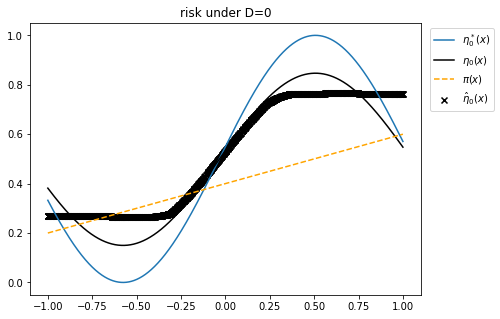

In [80]:
do=0
debug_info = {
    'val_x': x,
    'val_py': py_hat
}

viz_ccpe_estimates(expdf, debug_info, error_params, do, y0_pdf, y1_pdf, pi_pdf)




